In [290]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [291]:
import csv
import pymongo
import pprint
import sys, getopt
from bson.objectid import ObjectId
from pymongo import MongoClient
import re

In [292]:
connection = pymongo.MongoClient("mongodb://127.0.0.1:27017/?compressors=disabled&gssapiServiceName=mongodb")
mydb= connection.PreProcessor
mycol = mydb["Data_Cleaning"]
mycol_clean = mydb["Data_clean_after_analysis"]
mycol.drop()
mycol_clean.drop()
mydb.segment.drop()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymongo/compression_support.py:59: UserWarning: Unsupported compressor: disabled
  warnings.warn("Unsupported compressor: %s" % (compressor,))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymongo/common.py:797: UserWarning: Unknown option gssapiservicename
  warnings.warn(str(exc))


In [293]:
with open('tweets.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.DictReader(read_obj)
    # Pass reader object to list() to get a list of lists
    mylist = list(csv_reader)
    #print(list_of_rows)
    x_list = mycol.insert_many(mylist)

    #print list of the _id values of the inserted documents:

In [294]:
airline_tweets= pd.DataFrame(list(mycol.find()))

<AxesSubplot:ylabel='airline'>

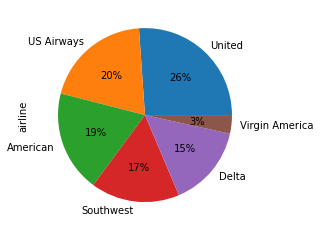

In [295]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

<AxesSubplot:ylabel='airline_sentiment'>

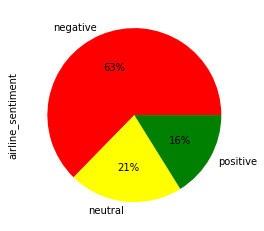

In [296]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<AxesSubplot:xlabel='airline'>

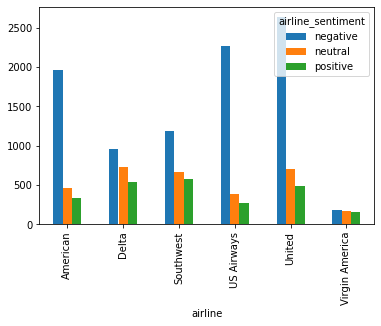

In [297]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [298]:
mycol.delete_many({"airline_sentiment_confidence" : {"$lt" : "1.0"}})
mycol.delete_many({ 
    "$and": [ 
        { "negativereason_confidence" : { "$lt": "1.0" } }, 
        { "airline_sentiment" : "negative" } 
        ] })

In [299]:
with open('tweets.csv', 'r') as read_obj_clean:
    # pass the file object to reader() to get the reader object
    csv_reader_clean = csv.DictReader(read_obj_clean)
    # Pass reader object to list() to get a list of lists
    mylist_clean = list(csv_reader_clean)
    #print(list_of_rows)
    y = mycol_clean.insert_many(mylist_clean)


In [300]:
mycol_clean.update_many({}, {'$unset': {'airline': 1, 'airline_sentiment_confidence' : 1, 'airline_sentiment_gold': 1, 'negativereason': 1, 'negativereason_gold': 1, 'tweet_coord': 1, 'tweet_created': 1, "tweet_location": 1, 'name' : 1,'retweet_count': 1, "negativereason_confidence": 1 , 'user_timezone': 1, 'tweet_id' : 1}})

In [301]:
pprint.pprint(mycol_clean.find_one())

{'_id': ObjectId('62e3568c18ee668c5fd0ec71'),
 'airline_sentiment': 'neutral',
 'text': '@VirginAmerica What @dhepburn said.'}


In [302]:
for doc in mycol.find(no_cursor_timeout=True):
            pk = ObjectId(str(doc.get("_id")))
            t = doc.get('text')
            if t:
               t = t.lower()
               t = t.replace("'ve"," have")
               t = t.replace("didn't","did not")
               t = t.replace("can't","cannot")
               t = t.replace("haven't","have not")
               t = t.replace("'re"," are") 
               t = t.replace("im","i am")
               t = t.replace("wont","will not")
               t = t.replace("couldn't","could not")
               t = t.replace("❤️","love")
               t = t.replace("☺️","happy")
               t = t.replace("👍","good job")
               t = re.sub('[0-9]', '', t)
            special_char = '!@#$%^&*()[]{};:,./<>?\|`~-=_+'
            for i in special_char:
                t = t.replace(i, '')
               
            mycol.update_one({"_id": pk}, {"$set":{"text":t}}) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymongo/collection.py:1643: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


In [303]:
tweets_Analysis_clean= pd.DataFrame(list(mycol.find()))

In [304]:
tweets_Analysis_clean.head()

,_id,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,62e3568a18ee668c5fd0b341,570306133677760513,neutral,1.0,,,Virgin America,,cairdin,,0,virginamerica what dhepburn said,,2015-02-24 11:35:52 -0800,,Eastern Time (US & Canada)
1,62e3568a18ee668c5fd0b345,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,,jnardino,,0,virginamerica and it's a really big bad thing ...,,2015-02-24 11:14:45 -0800,,Pacific Time (US & Canada)
2,62e3568a18ee668c5fd0b34a,570295459631263746,positive,1.0,,,Virgin America,,YupitsTate,,0,virginamerica it was amazing and arrived an ho...,,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)
3,62e3568a18ee668c5fd0b34c,570289724453216256,positive,1.0,,,Virgin America,,HyperCamiLax,,0,virginamerica i lt pretty graphics so much bet...,,2015-02-24 10:30:40 -0800,NYC,America/New_York
4,62e3568a18ee668c5fd0b34d,570289584061480960,positive,1.0,,,Virgin America,,HyperCamiLax,,0,virginamerica this is such a great deal alread...,,2015-02-24 10:30:06 -0800,NYC,America/New_York


In [305]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


In [306]:
features = tweets_Analysis_clean.iloc[:, 11].values
labels = tweets_Analysis_clean.iloc[:, 2].values

In [307]:
processed_features = []

for sentence in range(0, len(features)):
    processed_features.append(str(features[sentence]))

In [308]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [309]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [310]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [311]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [312]:
predictions = text_classifier.predict(X_test)

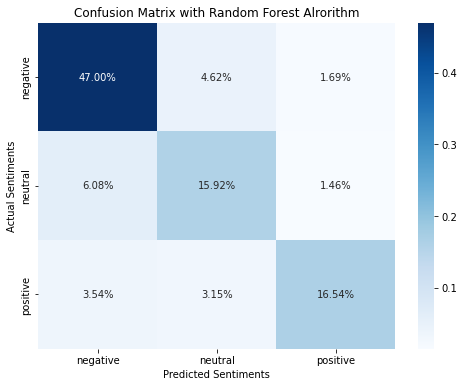

Classification Report with Random Forest Alrorithm
              precision    recall  f1-score   support

    negative       0.83      0.88      0.86       693
     neutral       0.67      0.68      0.68       305
    positive       0.84      0.71      0.77       302

    accuracy                           0.79      1300
   macro avg       0.78      0.76      0.77      1300
weighted avg       0.80      0.79      0.79      1300

Accuracy Score: 
0.7946153846153846


In [313]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

cf_matrix = confusion_matrix(y_test,predictions)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.set_title('Confusion Matrix with Random Forest Alrorithm');
ax.set_xlabel('Predicted Sentiments')
ax.set_ylabel('Actual Sentiments');
plt.show()

print('Classification Report with Random Forest Alrorithm')
print(classification_report(y_test,predictions))
print('Accuracy Score: ')
print(accuracy_score(y_test, predictions))

In [314]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
LR.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0)

In [315]:
predictions = LR.predict(X_test)

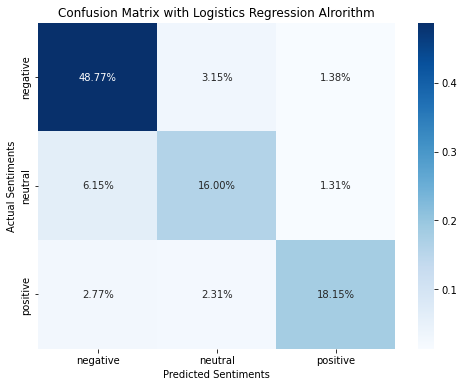

Classification Report with Logistics Regression Alrorithm
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88       693
     neutral       0.75      0.68      0.71       305
    positive       0.87      0.78      0.82       302

    accuracy                           0.83      1300
   macro avg       0.82      0.79      0.80      1300
weighted avg       0.83      0.83      0.83      1300

Accuracy Score: 
0.8292307692307692


In [316]:
cf_matrix = confusion_matrix(y_test,predictions)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.set_title('Confusion Matrix with Logistics Regression Alrorithm');
ax.set_xlabel('Predicted Sentiments')
ax.set_ylabel('Actual Sentiments');
plt.show()

print('Classification Report with Logistics Regression Alrorithm')
print(classification_report(y_test,predictions))
print('Accuracy Score: ')
print(accuracy_score(y_test, predictions))

In [317]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [318]:
predictions = KNN.predict(X_test)

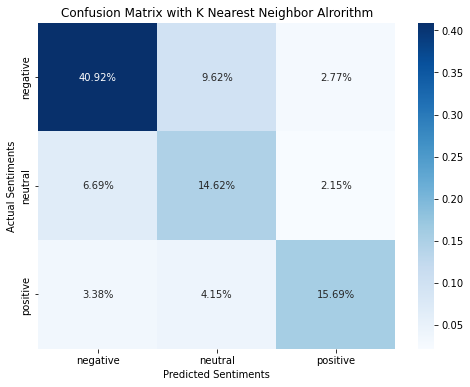

Classification Report with K Nearest Neighbor Alrorithm
              precision    recall  f1-score   support

    negative       0.80      0.77      0.78       693
     neutral       0.51      0.62      0.56       305
    positive       0.76      0.68      0.72       302

    accuracy                           0.71      1300
   macro avg       0.69      0.69      0.69      1300
weighted avg       0.73      0.71      0.72      1300

Accuracy Score: 
0.7123076923076923


In [319]:
cf_matrix = confusion_matrix(y_test,predictions)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.set_title('Confusion Matrix with K Nearest Neighbor Alrorithm');
ax.set_xlabel('Predicted Sentiments')
ax.set_ylabel('Actual Sentiments');
plt.show()

print('Classification Report with K Nearest Neighbor Alrorithm')
print(classification_report(y_test,predictions))
print('Accuracy Score: ')
print(accuracy_score(y_test, predictions))

In [321]:
def predict_sentiment(text):
    s_features = []
    s_features.append(text)
    testvect = vectorizer.transform(s_features).toarray()
    s_prediction = text_classifier.predict(testvect)
    return s_prediction[0]

In [322]:
predict_sentiment("I hate the work you did")

'negative'

In [323]:
import pickle
pickle.dump(LR, open('model.pkl', 'wb'))

In [324]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))